# SegCaps on Image Segmentation for Person
## Input Color image files
## Integrated with WebCam Video

A quick intro to using the pre-trained model to detect and segment object of person.

This notebook tests the model loading function from image file of a saved model.

In [1]:
import os
from os import path
from os.path import join, basename
import sys
import random
import math

import warnings
warnings.filterwarnings('ignore')

# import SimpleITK as sitk
import numpy as np
# import skimage.io
# import matplotlib
import matplotlib.pyplot as plt
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../')

from keras.utils import print_summary
from keras import layers, models

import segcapsnet.capsnet as modellib
import models.unet as unet

from utils.model_helper import create_model
from utils.load_2D_data import generate_test_batches, generate_test_image
from test import *
from PIL import Image
import scipy.ndimage.morphology
from skimage import measure, filters
from datetime import datetime


%matplotlib inline 

RESOLUTION = 512

# Root directory of the project
ROOT_DIR = path.dirname("../")
DATA_DIR = path.join(ROOT_DIR, "data")

# Directory to save logs and trained model
# MODEL_DIR = path.join(DATA_DIR, "saved_models/segcapsr3/m1.hdf5") # LUNA16

# Local path to trained weights file
# loss function = Dice is better than BCE (Binary Cross Entropy)
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/dice16-255.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/capsbasic/mcb11-r0.1.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/mar10-255.hdf5") # MSCOCO17
# COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/segcapsr3/bce.hdf5") # MSCOCO17
COCO_MODEL_PATH = path.join(DATA_DIR, "saved_models/unet/unet1.hdf5") # MSCOCO17


# Directory of images to run detection on
IMAGE_DIR = path.join(DATA_DIR, "imgs")

Using TensorFlow backend.


## Create Model and Load Trained Weights

In [2]:
# Create model object in inference mode.
net_input_shape = (RESOLUTION, RESOLUTION, 1)
num_class = 2
# train_model, eval_model, manipulate_model = modellib.CapsNetR3(net_input_shape, num_class)
# train_model, eval_model, manipulate_model = modellib.CapsNetBasic(net_input_shape, num_class)
eval_model = unet.UNet(net_input_shape)

# Load weights trained on MS-COCO
eval_model.load_weights(COCO_MODEL_PATH)
print_summary(model=eval_model)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [3]:

def threshold_mask(raw_output, threshold):
    if threshold == 0:
        try:
            threshold = filters.threshold_otsu(raw_output)
        except:
            threshold = 0.5

    print('\tThreshold: {}'.format(threshold))

    raw_output[raw_output > threshold] = 1
    raw_output[raw_output < 1] = 0

    all_labels = measure.label(raw_output)
    props = measure.regionprops(all_labels)
    props.sort(key=lambda x: x.area, reverse=True)
    thresholded_mask = np.zeros(raw_output.shape)

    if len(props) >= 2:
        if props[0].area / props[1].area > 5:  # if the largest is way larger than the second largest
            thresholded_mask[all_labels == props[0].label] = 1  # only turn on the largest component
        else:
            thresholded_mask[all_labels == props[0].label] = 1  # turn on two largest components
            thresholded_mask[all_labels == props[1].label] = 1
    elif len(props):
        thresholded_mask[all_labels == props[0].label] = 1

    thresholded_mask = scipy.ndimage.morphology.binary_fill_holes(thresholded_mask).astype(np.uint8)

    return thresholded_mask


## Predict the Segmentation of Person



In [4]:

img = ['train2.png']
output_array = None


# sitk_img = sitk.ReadImage(join(IMAGE_DIR, img[0]))
# img_data = sitk.GetArrayFromImage(sitk_img)
img_data = np.asarray(Image.open(join(IMAGE_DIR, img[0])))

    
print(str(datetime.now()))
output_array = eval_model.predict_generator(generate_test_batches(DATA_DIR, [img],
                                                                  net_input_shape,
                                                                  batchSize=1,
                                                                  numSlices=1,
                                                                  subSampAmt=0,
                                                                  stride=1),
                                            steps=1, max_queue_size=1, workers=1,
                                            use_multiprocessing=False, verbose=1)
print(str(datetime.now()))

2018-06-29 19:40:01.800378
1/1 [==============================] - 12s 12s/step
2018-06-29 19:40:13.839906


In [5]:
# output_array contain 2 masks in a list, show the first element.
# print('len(output_array)=%d'%(len(output_array)))
# print('test.test: output_array=%s'%(output_array[0]))


In [6]:
# output = (1, 512, 512)
# output = output_array[0][:,:,:,0] # A list with two images, get first one image and reshape it to 3 dimensions.
# recon = output_array[1][:,:,:,0]

# For unet
output = output_array[:,:,:,0]
# image store in tuple structure.
print('test.test: output=%s'%(output))
np.ndim(output)
np_output = np.array(output)





test.test: output=[[[1.4466044e-05 1.1694666e-07 5.0560070e-11 ... 1.5000023e-14
   1.0684551e-11 8.5299781e-08]
  [1.6659870e-08 8.7757562e-12 8.0746716e-18 ... 1.5780187e-21
   1.1092096e-18 1.3635808e-11]
  [9.2842270e-12 9.5348995e-16 6.7766995e-23 ... 8.6596671e-30
   1.7681853e-23 1.0862065e-15]
  ...
  [4.5826747e-09 1.8415758e-13 5.0473560e-18 ... 0.0000000e+00
   0.0000000e+00 1.2625617e-23]
  [1.9315365e-07 2.9524030e-10 2.4017474e-14 ... 0.0000000e+00
   2.1241745e-31 1.9331992e-22]
  [1.6580844e-04 5.6898688e-07 3.0368263e-08 ... 1.1825515e-24
   1.0700544e-18 6.9664417e-12]]]


In [7]:
# output_img = sitk.GetImageFromArray(output[0,:,:], isVector=True)

print('Segmenting Output')
threshold_level = 0
output_bin = threshold_mask(output, threshold_level)
# output2d = output[0,:,:]
# output2d = recon[0,:,:]
# print(output2d)

Segmenting Output
	Threshold: 0.0013444753612930072


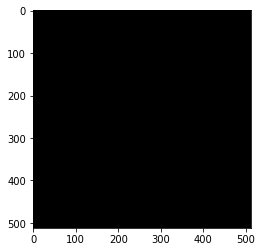

In [8]:
# plt.imshow(output[0,:,:], cmap='gray')
# plt.imsave('raw_output' + img[0][-4:], output[0,:,:])
plt.imshow(output_bin[0,:,:], cmap='gray')
# plt.imsave('final_output' + img[0][-4:], output_bin[0,:,:])


In [9]:

# mask = output2d[...] > threshold_level


# Set all masked pixels to zero
# masked = img_data.copy()
# masked[mask] = 0
# # print(masked)
# # output_mask = sitk.GetImageFromArray(output_bin[0,:,:], isVector=True)
# #     output_img = np.reshape(output_img, [512, 512, 1])
# #     output_mask = np.reshape(output_mask, [512, 512, 1])

# Display original and masked images side-by-side
# print('threshold_level=%f'%threshold_level)
# plt.figure()
# f, (ax0, ax1) = plt.subplots(1, 2)

# ax0.imshow(img_data)
# ax1.imshow(masked)
# plt.axis('off')


# cv2.imshow("Masked",masked)
# cv2.waitKey(0)

In [10]:
plt.imshow(output2d, cmap=plt.cm.Greys_r)
plt.axis('off');
# plt.imsave('./output_img.png', output2d)

NameError: name 'output2d' is not defined

# Integrate with Video Stream

In [11]:
from threading import Thread
import cv2
import colorsys
from IPython import display
import signal


### Class definition for FPS calculation and webcam threading.

#### Reference
1. Adrian Rosebrock, imutils, https://github.com/jrosebr1/imutils/tree/master/imutils/video

In [12]:
class FPS:
    def __init__(self):
        # store the start time, end time, and total number of frames
        # that were examined between the start and end intervals
        self._start = None
        self._end = None
        self._numFrames = 0

    def start(self):
        # start the timer
        self._start = datetime.now()
        return self

    def stop(self):
        # stop the timer
        self._end = datetime.now()

    def update(self):
        # increment the total number of frames examined during the
        # start and end intervals
        self._numFrames += 1

    def elapsed(self):
        # return the total number of seconds between the start and
        # end interval
        return (self._end - self._start).total_seconds()

    def fps(self):
        # compute the (approximate) frames per second
        return self._numFrames / self.elapsed()

class WebcamVideoStream:
    def __init__(self, src=0, name="WebcamVideoStream"):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()

        # initialize the thread name
        self.name = name
        
        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False


    def start(self):
        # start the thread to read frames from the video stream
        t = Thread(target=self.update, name=self.name, args=())
        t.daemon = True
        t.start()
        return self
    
    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return
            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()           
            
    def read(self):
        # return the frame most recently read
        return self.frame

    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True


### Major display function definitions

In [13]:
def random_colors(N):
    np.random.seed(70)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

def apply_mask(image, mask, color, alpha=0.4):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1+2, y1-7), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image

### Define a signal function to capture the interruption.

In [14]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

## Main Program

In [15]:
def get_model (model_path, net_input_shape, num_class):
    train_model, eval_model, manipulate_model = modellib.CapsNetR3(net_input_shape, num_class)

    # Load weights trained on MS-COCO
    eval_model.load_weights(model_path)

    class_names = ['person']
    return class_names, eval_model


### Interrupt the kernel to stop the capture or wait for 50 frames processing


In [16]:
if __name__ == '__main__':
    net_input_shape = (RESOLUTION, RESOLUTION, 1)
    num_class = 2    
    class_names, model = get_model(COCO_MODEL_PATH, net_input_shape, num_class)

    # created a *threaded* video stream, allow the camera sensor to warmup,
    # and start the FPS counter
    print("[INFO] sampling THREADED frames from webcam...")
    vs = WebcamVideoStream(src=0).start()
    fps = FPS().start()
    frame = vs.read()
    
    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False

    # loop over 50 frames...this time using the threaded stream
    while fps._numFrames < 50:
        # grab the frame from the threaded video stream
        frame = vs.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # check to see if the frame should be displayed to our screen
        results = model.predict_generator(generate_test_image(
                                        test_img=frame, net_input_shape=net_input_shape,
                                        batchSize=1, numSlices=1,
                                        subSampAmt=0, stride=1, downSampAmt=1),
                                        steps=1, max_queue_size=1, workers=1,
                                        use_multiprocessing=False, verbose=1)
        
        
        r = results[0]
        frame = display_instances(
                frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
        )
        # check to see if the frame should be displayed to our screen
        
        plt.imshow(frame)
        display.clear_output(wait=True)

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(5.05) # the pause time
        except Exception:
            pass
        # update the FPS counter
        fps.update()
        if is_interrupted:
            break
    # stop the timer and display FPS information
    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
 
    # do a bit of cleanup
    vs.stop()
#     cv2.destroyAllWindows()
   
    

[INFO] sampling THREADED frames from webcam...
1/1 [==============================] - 83s 83s/step


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices